In [18]:
import duckdb
from __future__ import annotations
from sklearn.cluster import KMeans
import pyarrow
import numpy as np 
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Optional, Union


In [19]:
def sample_ids_from_parquet(
    parquet_path: str | Path, 
    id_column: str = "rinpersoon_id", 
    n: int = 1000, 
    seed: Optional[int] = None
) -> pl.DataFrame:
    """
    Sample n random IDs from a Parquet file and return a DataFrame with all columns
    for those sampled IDs.
    
    Parameters:
    -----------
    parquet_path : str or Path
        Path to the Parquet file
    id_column : str, default="rinpersoon_id"
        Name of the ID column to sample from
    n : int, default=1000
        Number of IDs to sample
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    pl.DataFrame
        DataFrame containing all columns for the sampled IDs
    """
    # Convert to Path object if string is provided
    if isinstance(parquet_path, str):
        parquet_path = Path(parquet_path)

    rng = np.random.default_rng(seed)
    
    # Step 1: Read only the ID column to minimize memory usage
    try:
        ids_df = pl.scan_parquet(parquet_path).select(id_column).collect()
    except Exception as e:
        raise Exception(f"Error reading ID column from Parquet file: {e}")
    
    # Step 2: Sample n unique IDs
    unique_ids = ids_df[id_column].unique()
    total_ids = len(unique_ids)
    
    if total_ids < n:
        print(f"Warning: Requested {n} samples but file only contains {total_ids} unique IDs.")
        n = total_ids
    
    sampled_ids = rng.choice(unique_ids, n, replace=False)
    
    # Step 3: Query the Parquet file to get all columns for the sampled IDs
    try:
        result_df = (
            pl.scan_parquet(parquet_path)
            .filter(pl.col(id_column).is_in(sampled_ids))
            .collect()
        )
        
        print(f"Successfully sampled {len(result_df)} rows for {n} unique IDs.")
        return result_df
    
    except Exception as e:
        raise Exception(f"Error querying Parquet file for sampled IDs: {e}")


In [20]:
def create_fake_embs(n=1_000, k=128):
    rng = np.random.default_rng()
    n = 1_000
    k = 128
    embs = rng.normal(size=(n,k))
    ids = rng.choice(np.arange(1_000_000, 100_000_000), n, replace=False)
    ids.dtype = np.int64
    return np.hstack([np.expand_dims(ids,1), embs])

In [21]:
embs = create_fake_embs()

In [22]:
n_clusters = 100


In [23]:
def get_clusters(estimator, n_clusters, data):
    ids, X = (data[:, 0], data[:, 1:])
    estimator.n_clusters = n_clusters
    estimator.fit(X)
    clusters = np.vstack([ids, estimator.labels_]).T
    cluster_df = pl.DataFrame(
        clusters,
        schema=["id", "cluster"],
        orient="row"
    )
    
    # Cast columns to appropriate types
    cluster_df = cluster_df.with_columns([
        pl.col("id").cast(pl.Int64),
        pl.col("cluster").cast(pl.Int64)
    ])
    return cluster_df, estimator.cluster_centers_


def summarise_cluster(cluster_df):
    summary = (cluster_df
    .group_by("cluster")
    .agg([
        pl.len().alias("count"),
        pl.col("id").min().alias("min_id"),
        pl.col("id").max().alias("max_id"),
        pl.col("id").mean().alias("avg_id")
    ])
    .sort("cluster")
    )
    return summary


def barplot_cluster_sizes(cluster_df):
    """
    Create a bar plot of cluster sizes and return the figure object for further handling.
    
    Parameters:
    -----------
    cluster_df : DataFrame
        DataFrame containing cluster data
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object which can be displayed or saved
    """
    summary = summarise_cluster(cluster_df)
    
    cluster_ids = summary["cluster"].to_numpy()
    counts = summary["count"].to_numpy()
    
    # Create figure explicitly and get the figure object
    fig = plt.figure(figsize=(10, 6))
    
    # Create the plot on the current figure
    bars = plt.bar(cluster_ids, counts, color='skyblue', edgecolor='navy')
    
    plt.title('Number of Items per Cluster', fontsize=15)
    plt.ylabel('Count', fontsize=12)
    plt.ylim(0, max(counts) * 1.15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Apply tight layout to ensure proper spacing
    plt.tight_layout()
    
    # Return the figure object
    return fig



In [24]:
kmeans = KMeans(random_state=0, n_init="auto")
cluster_df, cluster_centers = get_clusters(kmeans, n_clusters, embs)
cluster_df.head()

id,cluster
i64,i64
43541356,97
75455710,73
70383112,71
10638319,6
44592855,68


In [27]:
cluster_centers.shape

(100, 128)

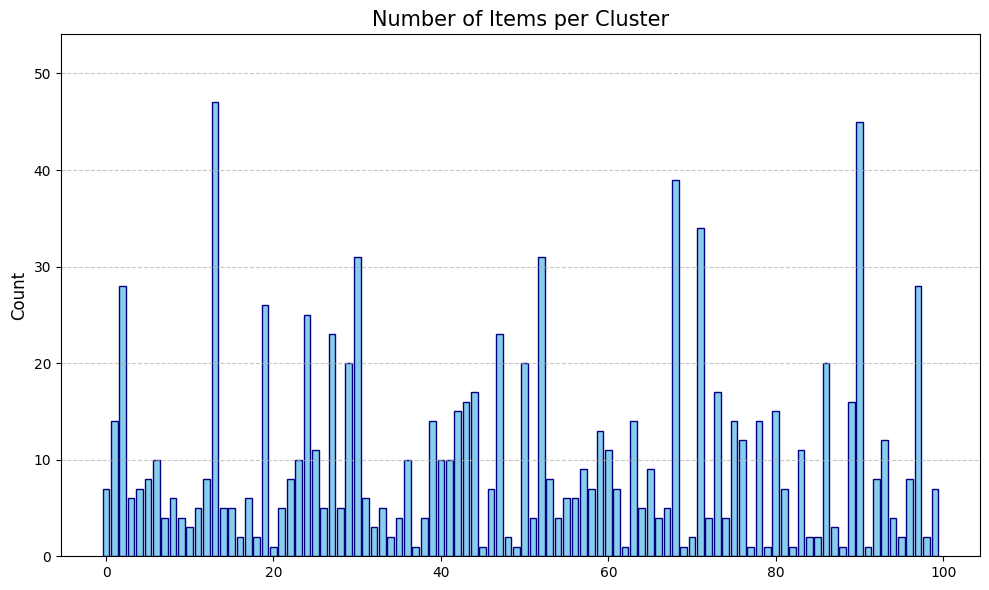

In [25]:
plt = barplot_cluster_sizes(cluster_df)

In [17]:
# plt.savefig("test.png")